<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/tesis/notebooks/10-BoW%2BSVM%2Bfeature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combinaciones de estrategias de etiquetado + SVM

__Carrera:__ Maestria en Inteligencia de datos orientada a Big Data de la Universidad Nacional de La Plata.

___Título de la Tesis:___ Clasificación automática de correos electrónicos

___Autor:___ Juan Manuel Fernandez

___Director:___ Marcelo Errecalde

__Objetivo:__ En esta notebook se presentan los experimentos a partir de los datos etiquetados manualmente junto con los automáticos a partir de las features extraidas del train dataset con todas las combinaciones de estrategias de selección de características + las combinaciones de estrategias de representación de documentos (pesados binario y tf-idf, 3-4-gramas de caracteres y 1-2-gramas de palabras) + la construcción de un clasificador con SVM (máquinas vector soporte).

## 0. Configuración de la ejecución

A continuación se genera la configuración de las estrategias que integrarán el sistema de votación para la obtención de instancias:

In [1]:
# Posibilidades : lr, ss3, tfidf
# Combinaciones:
# lr-ss3
# lr-tfidf
# ss3-tfidf
# lr-ss3-tfidf
estrategias_feature_extraction = []

# Se define si se incorporan las instancias definidas manualmente
ETIQUETADO_MANUAL = True

# Para el sistema de votación queda fija la cantidad de instancias
CANTIDAD_INSTANCIAS = 200
BOOSTING = False

# Defino una lista con los esquemas de representación y la cantidad de tokens
estrategias_representacion = ['BINARIO', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
ATRIBUTOS_DINAMICOS = 3000

# Defino la técnica de ML
tecnica = 'SVM'

Se definen algunas características fijas:

In [2]:
# El archivo de test y el train con etiquetado manual es siempre el mismo
TRAIN_FILE_MANUAL = '02-01-correos-train-80.csv'
TEST_FILE = '02-02-correos-test-20.csv'
atributos_df = ['consulta', 'dia_semana', 'semana_del_mes', 'mes', 'cuatrimestre',
                  'anio', 'hora_discretizada', 'dni_discretizado', 'legajo_discretizado',
                  'posee_legajo', 'posee_telefono', 'carrera_valor', 'proveedor_correo',
                  'cantidad_caracteres', 'proporcion_mayusculas', 'proporcion_letras',
                  'cantidad_tildes', 'cantidad_palabras', 'cantidad_palabras_cortas',
                  'proporcion_palabras_distintas', 'frecuencia_signos_puntuacion',
                  'cantidad_oraciones', 'utiliza_codigo_asignatura', 'score']

Y se generan los datos en función de la cantidad de estrategias a utilizar:

In [3]:
# Se genera el nombre del archivo de instancias a ejecutar en función de las estrategias

# En caso que se realice el ensamble entre las n estrategias
if len(estrategias_feature_extraction)>=1:
  if BOOSTING:
    TRAIN_FILE_E0 = f'dataset-{estrategias_feature_extraction[0]}-200-boosting-prep.csv'
  else:
    TRAIN_FILE_E0 = f'dataset-{estrategias_feature_extraction[0]}-200-prep.csv'
  texto = f'Los dataset a utilizar son: \n\t{TRAIN_FILE_E0}'
  # Se define el if para que ante reiteradas ejecuciones de la notebook no se vuelva a insertar
  if 'clase_e0' not in atributos_df:
    atributos_df.append('clase_e0')

if len(estrategias_feature_extraction)>=2:
  if BOOSTING:
    TRAIN_FILE_E1 = f'dataset-{estrategias_feature_extraction[1]}-200-boosting-prep.csv'
  else:
    TRAIN_FILE_E1 = f'dataset-{estrategias_feature_extraction[1]}-200-prep.csv'
  texto = texto + f'\n\t{TRAIN_FILE_E1}'
  # Se define el if para que ante reiteradas ejecuciones de la notebook no se vuelva a insertar
  if 'clase_e1' not in atributos_df:
    atributos_df.append('clase_e1')

# En caso que se realice el ensamble entre las 3 estrategias
if len(estrategias_feature_extraction)==3:
  if BOOSTING:
    TRAIN_FILE_E2 = f'dataset-{estrategias_feature_extraction[2]}-200-boosting-prep.csv'
  else:
    TRAIN_FILE_E2 = f'dataset-{estrategias_feature_extraction[2]}-200-prep.csv'

  texto = texto + f'\n\t{TRAIN_FILE_E2}' 
  # Se define el if para que ante reiteradas ejecuciones de la notebook no se vuelva a insertar
  if 'clase_e2' not in atributos_df:
    atributos_df.append('clase_e2')

if len(estrategias_feature_extraction)>=1:
  print(texto)

## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [4]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=ae85c09266e5acb3c696a7a3a4fd8c57fdbdbe45508cf109a5b6a27ae7d6d155
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [5]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df, generar_train_test_set

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [6]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### 1.2.1. Carga de librerías de procesamiento de texto

Se cargan en memoria dos funciones: _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __SVM__ y _representacion_documentos_ que genera representaciones para las _features textuales_:

In [7]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos, gridsearch_por_tecnica

### 1.3. Carga de datos

Cargo la librería warnings para no mostrar las advertencias, pandas para el manejo de df y os para verificar la existencia de los archivos en la carga de datos. Además, cargo en memoria la URL de base de los datasets y una lista de las etiquetas de las distintas clases:

In [8]:
import warnings
import pandas as pd
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
# SS = datos con etiquetados semi-supervisados
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/'
DS_DIR_SS = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/03-elasticsearch/procesados/'

# Defino las clases y la cantidad a utilizar
etiquetas = get_clases()
CANTIDAD_CLASES = len(etiquetas)

Se cargan los dataframe en memoria con el preprocesamiento de los datos:
- Instancias LR,
- Instancias SS3,
- Instancias TFIDF.
- Instancias etiquetadas manualmente.


In [9]:
if len(estrategias_feature_extraction)>=1:
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_E0))

  df_e0, test_df, etiquetas = cargar_dataset(DS_DIR_SS, TRAIN_FILE_E0, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
  df_e0['consulta'] = pd.Series(preprocesar_correos(df_e0['consulta']))
  test_df['consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(df_e0.clase.unique()), df_e0.clase.unique()))

  # Me quedo con las N cantidad de instancias con mayor score por clase
  if CANTIDAD_INSTANCIAS<200:
    df_e0 = df_e0.sort_values(['clase','score'], ascending=False).groupby('clase').head(CANTIDAD_INSTANCIAS).reset_index(drop=True)
    df_e0 = df_e0.sample(frac = 1)


Solo en el caso que decida hacer el sistema de votación entre al menos 2 estrategias inicializo la segunda:

In [10]:
if len(estrategias_feature_extraction)>=2:
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_E1))

  df_e1, test_df_e1, etiquetas = cargar_dataset(DS_DIR_SS, TRAIN_FILE_E1, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Se ejecuta el preprocesamiento de correos sobre el campo consulta
  df_e1['consulta'] = pd.Series(preprocesar_correos(df_e1['consulta']))

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(df_e1.clase.unique()), df_e1.clase.unique()))

  # Me quedo con las N cantidad de instancias con mayor score por clase
  if CANTIDAD_INSTANCIAS<200:
    df_e1 = df_e1.sort_values(['clase','score'], ascending=False).groupby('clase').head(CANTIDAD_INSTANCIAS).reset_index(drop=True)
    df_e1 = df_e1.sample(frac = 1)


Solo en el caso que decida hacer el sistema de votación entre las 3 estrategias inicializo la tercera:

In [11]:
if len(estrategias_feature_extraction)>=3:
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_E2))

  df_e2, test_df_e2, etiquetas = cargar_dataset(DS_DIR_SS, TRAIN_FILE_E2, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Se ejecuta el preprocesamiento de correos sobre el campo consulta
  df_e2['consulta'] = pd.Series(preprocesar_correos(df_e2['consulta']))

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(df_e2.clase.unique()), df_e2.clase.unique()))

  # Me quedo con las N cantidad de instancias con mayor score por clase
  if CANTIDAD_INSTANCIAS<200:
    df_e2 = df_e2.sort_values(['clase','score'], ascending=False).groupby('clase').head(CANTIDAD_INSTANCIAS).reset_index(drop=True)
    df_e2 = df_e2.sample(frac = 1)


Verifico si voy a acumular los datos etiquetados manualmente a los de etiquetado no supervisado y en caso afirmativo los cargo en memoria:

In [12]:
if ETIQUETADO_MANUAL:
 
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_MANUAL))

  train_df_manual, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_MANUAL, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
  train_df_manual['consulta'] = pd.Series(preprocesar_correos(train_df_manual['consulta']))

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(train_df_manual.clase.unique()), train_df_manual.clase.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


### 1.4 Sistema de votación entre estrategias de _feature extraction_

En primer lugar, se joinea mediante el texto de la consulta las estrategias encaradas (según sean dos o tres):

In [13]:
import pandas as pd

# Si se utiliza sólo 1 estrategia, se inicializa el df_join con solo esa
if len(estrategias_feature_extraction)==1:
  df_join = df_e0

# Si se utilizan al menos 2 estrategias, se incorpora también la 2da
if len(estrategias_feature_extraction)>=2:
  df_join = pd.merge(df_e0, df_e1, on='consulta', how='left', suffixes=(None, "_x"))

# Si están las 3 estrategias, se incorpora también la 3era
if len(estrategias_feature_extraction)==3:
  df_join = pd.merge(df_join, df_e2, on='consulta', how='left', suffixes=(None, "_y"))

Borro las instancias con faltantes y verifico el resultado la dimensionalidad del df:

In [14]:
if 'df_join' in globals():
  df_join = df_join.dropna()
  
  print(df_join.shape)

  print(df_join.head())

Renombro las clases en función de las estrategias y me quedo sólo con las instancias en que la clase coincide:

In [15]:
if len(estrategias_feature_extraction)==3:
  df_join.rename(columns={'clase_x': 'clase_e0', 'clase_y': 'clase_e1', 'clase': 'clase_e2'}, inplace=True)
  df_join['match_clase'] = ((df_join['clase_e0'] == df_join['clase_e1']) & (df_join['clase_e1'] == df_join['clase_e2']))
elif len(estrategias_feature_extraction)==2:
  df_join.rename(columns={'clase': 'clase_e0', 'clase_x': 'clase_e1'}, inplace=True)
  df_join['match_clase'] = df_join['clase_e0'] == df_join['clase_e1']
elif len(estrategias_feature_extraction)==1:
  df_join.rename(columns={'clase': 'clase_e0'}, inplace=True)
  # Esto se hace por compatibilidad con las otras alternativas (2 y 3 estrategias)
  df_join['match_clase'] = df_join['clase_e0'] == df_join['clase_e0']

if 'df_join' in globals():
  # Me quedo sólo con las instancias en que la clase coincide
  train_df_join = df_join.query('match_clase == True').reset_index()

  train_df_join.shape

Me quedo solo con los atributos que me interesan (elimino duplicados):

In [16]:
if 'df_join' in globals():
  train_df_join = train_df_join[atributos_df]

  train_df_join.columns

Me quedo sólo con una columna de clase dado que son las 3 iguales:

In [17]:
if 'df_join' in globals():
  # Tomo una clase al azar, dado que coinciden las 3
  train_df_join.rename(columns={'clase_e0': 'clase'}, inplace=True)

  # Elimino las columnas que no necesito
  if len(estrategias_feature_extraction)>=2:
    train_df_join.drop(['clase_e1'], inplace=True, axis=1)

  if len(estrategias_feature_extraction)==3:
    train_df_join.drop(['clase_e2'], inplace=True, axis=1)

  train_df_join.shape

Me guardo la columna del score de Elasticsearch para no generar incompatibilidades:

In [18]:
if 'df_join' in globals():
  score = train_df_join['score']
  train_df_join.drop('score', inplace=True, axis=1)

In [19]:
if len(estrategias_feature_extraction)>=1:
  if ETIQUETADO_MANUAL:
    train_df = pd.concat([train_df_manual, train_df_join], axis=0).reset_index(drop=True)
  else:
    train_df = train_df_join
else:
  train_df = train_df_manual

Muestro el dataframe resultante:

In [20]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
train_df.head()

,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
0,queria saber puedo acceder boleto estudiantil ...,6,2,3,1,2019,2,7,4,1,1,3,4,107,0.0,0.775701,3,21,12,0.952381,0.000000,1,0,Boleto Universitario
1,puedo reseterar clave acceso sistema web ayer ...,4,2,12,2,2015,0,2,1,1,1,5,6,419,0.0,0.809069,0,78,45,0.717949,0.007160,1,0,Problemas con la Clave
2,dice beneficio sube quiero saber situacion,1,2,4,1,2019,3,8,4,1,1,3,6,96,0.0,0.781250,1,22,15,0.863636,0.000000,1,0,Boleto Universitario
3,buenos dias queria consultar puedo anotar tall...,3,4,10,2,2018,1,4,2,1,1,3,6,410,0.0,0.819512,5,70,34,0.728571,0.012195,2,0,Cursadas
4,buenas tardes quiero volver estudiar facultad ...,2,1,2,1,2019,0,2,0,0,1,54,6,175,0.0,0.811429,1,32,16,0.875000,0.011429,1,0,Cambio de Carrera


In [21]:
X_train, y_train, X_test, y_test = generar_train_test_set(train_df, test_df, '3-4-NGRAM-CHARS', MAX_TKS=ATRIBUTOS_DINAMICOS)

Estrategia de representación: 3-4-NGRAM-CHARS


In [22]:
X_train.shape

(800, 3022)

## 2. SVM

### 2.1 Modelo general (clasificación en las 16 clases)

En primer lugar se trabaja con un único clasificador que clasifica y testea las instancias en las 16 clases posibles.

#### 2.1.1 Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [23]:
# Defino los parámetros para GridSearchCV
params_svm = {'SVM__C': [0.1, 1, 10], 
              'SVM__gamma': [0.01, 0.1, 1],
              'SVM__class_weight': [None, 'balanced'],
              'SVM__kernel': ['rbf', 'linear', 'sigmoid'],
              'SVM__probability': [False]
              }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [24]:
modelos_grid = []
representacion_grid = []
metricas_grid = []
NO_CORRIDA = True

# Modulo para la hora (a efectos de calcular los tiempos de ejecución)
import time

if NO_CORRIDA:
  # Se hace una búsqueda grid por estrategia de representación
  for estrategia in estrategias_representacion:
    
    # Generamos los datos de train y test por estrategia
    X_train, y_train, X_test, y_test = generar_train_test_set(train_df, test_df, estrategia, MAX_TKS=ATRIBUTOS_DINAMICOS)

    # Se imprime la hora del servidor
    hora_servidor = time.strftime('%H:%M:%S', time.localtime())
    print(f'Hora de inicio de la búsqueda grid: {hora_servidor}.')

    # Llamo a la función que realiza el gridsearch por estrategia  
    clf_grid, metrics_grid = gridsearch_por_tecnica(X_train, y_train, X_test, y_test, tecnica, params_svm)

    # Guardamos el mejor modelo para cada estrategia de representación
    modelos_grid.append(clf_grid)
    representacion_grid.append(estrategia)
    metricas_grid.append(metrics_grid)

Estrategia de representación: BINARIO
Hora de inicio de la búsqueda grid: 18:52:04.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Parámetros: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': False}
Accuracy Test-Set: 0.745
Métricas sobre Test-Set: {'accuracy': 0.745, 'precision': 0.7473571428571428, 'recall': 0.745, 'f1_score': 0.7382868301819316, 'mcc': 0.7095105249896024}
Estrategia de representación: TFIDF
Hora de inicio de la búsqueda grid: 18:55:18.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Parámetros: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'SVM__probability': False}
Accuracy Test-Set: 0.7
Métricas sobre Test-Set: {'accuracy': 0.7, 'precision': 0.7190727687626775, 'recall': 0.7, 'f1_score': 0.6963380927317745, 'mcc': 0.6578107705206261}
Estrategia de representación: 3-4-NGRAM-CHARS
Hora de inicio de la búsqueda grid: 18:58:52.
F

A partir de los mejores hiperparámetros encontrados para cada estrategia de representación de correos, se busca cual es la estrategia que generó el mayor _accuracy_ (medida totalmente arbitraria):

In [25]:
max_accuracy = 0
for i in range(1, len(metricas_grid)):
  if metricas_grid[i]['accuracy'] > metricas_grid[max_accuracy]['accuracy']:
    max_accuracy = i

representacion_max = representacion_grid[max_accuracy]

# Se le quita el prefijo asignado a los parametricos para la búsqueda grid
params_max = params = {x.replace("SVM__", ""): v for x, v in modelos_grid[max_accuracy].best_params_.items()}

# Se guardan las métricas y el modelo "ganador"
metricas_max = metricas_grid[max_accuracy]
clf_max = modelos_grid[max_accuracy]

print(f'Sistema de generación de instancias: {estrategias_feature_extraction}', sep="")
if ETIQUETADO_MANUAL and (len(estrategias_feature_extraction)>=1):
  print(f'Las instancias se ACUMULAN a las etiquetadas manualmente')
else:
  print(f'Las instancias NO SE ACUMULAN a las etiquetadas manualmente')

print(f'El modelo más eficaz es {tecnica} con la estrategia de representación {representacion_max} y los parámetros:\n {params_max}')
print(f'El modelo brinda las siguientes métricas de selección:\n {metricas_max}')

Sistema de generación de instancias: []
Las instancias NO SE ACUMULAN a las etiquetadas manualmente
El modelo más eficaz es SVM con la estrategia de representación 3-4-NGRAM-CHARS y los parámetros:
 {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'linear', 'probability': False}
El modelo brinda las siguientes métricas de selección:
 {'accuracy': 0.8, 'precision': 0.7936884574519464, 'recall': 0.8, 'f1_score': 0.7911445565762963, 'mcc': 0.7708036472669705}


#### 2.1.2 Modelo generado

En función de los mejores hiperparámetros y estrategia de representación encontrados con la búsqueda Grid, ajusto el modelo para obtener las métricas.

En primer lugar genero los datos de train y test con la estrategia de representación ganadora:

In [26]:
X_train, y_train, X_test, y_test = generar_train_test_set(train_df, test_df, representacion_max, MAX_TKS=ATRIBUTOS_DINAMICOS)

Estrategia de representación: 3-4-NGRAM-CHARS


__[VARIANTE]__ Se entrena el modelo con los mejores hiperparámetros encontrados:

In [27]:
# Accuracy: 0.8 Etiquetado Manual
# Parámetros: {'SVM__C': 0.1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'linear', 'SVM__probability': False}

# from sklearn.svm import SVC
# clf = SVC(**params_max)

# Entreno el modelo con los parámetros
# clf.fit(X_train, y_train)

Se predicen las instancias de testeo:

In [28]:
y_pred = clf_max.predict(X_test)

#### 2.1.3 Métricas de selección

In [29]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.8
                                     precision    recall  f1-score   support

               Boleto Universitario       0.98      0.98      0.98        48
                  Cambio de Carrera       0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.67      0.80         3
                Consulta por Legajo       0.50      0.67      0.57         3
Consulta sobre Título Universitario       0.50      0.33      0.40         3
                           Cursadas       0.57      0.89      0.69        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.60      0.60      0.60         5
           Ingreso a la Universidad       0.90      0.79      0.84        33
             Pedido de Certificados       0.88      1.00      0.94        15
             Problemas con la Clave       0.90      0.83     

Se genera la matriz de confusión del modelo:

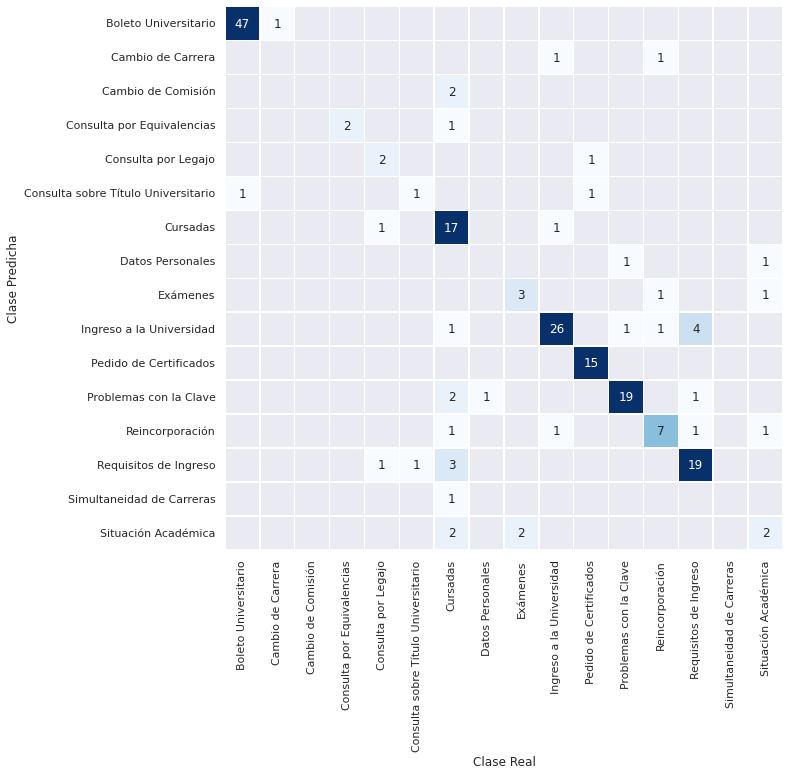

In [36]:
import numpy as np
from sklearn import metrics #Importar el módulo metrics de scikit-learn
import seaborn as sns
import matplotlib.pyplot as plt

matriz_confusion = metrics.confusion_matrix(y_test, y_pred)

sns.set()
my_mask = np.zeros((matriz_confusion.shape[0], matriz_confusion.shape[0]), dtype=int)
for i in range(matriz_confusion.shape[0]):
    for j in range(matriz_confusion.shape[0]):
        my_mask[i][j] = matriz_confusion[i][j] == 0 
  
fig_dims = (10, 10)
plt.subplots(figsize=fig_dims)

ax = sns.heatmap(matriz_confusion,
                 xticklabels=etiquetas,
                 annot=True, 
                 fmt="d", 
                 linewidths=.5, 
                 cmap="Blues", 
                 cbar=False, 
                 mask=my_mask, 
                 vmax=15)

plt.gcf().set_size_inches(10, 10)
plt.xticks(rotation=90, ha="center")
plt.yticks(np.arange(len(etiquetas))+0.5, etiquetas, rotation='horizontal')

plt.xlabel('Clase Real')
plt.ylabel('Clase Predicha');

### 3. Análisis del error

Se consolida un dataframe para hacer el análisis de la performance:

In [43]:
df_train_error = {'clase': pd.Series(train_df.clase.unique()), 
                  'count_train': train_df.clase.value_counts().reset_index(drop=True)}
  
df_train_error = pd.DataFrame(df_train_error)

# Calculo el accuracy por clase
avg_class = matriz_confusion.diagonal()/matriz_confusion.sum(axis=1)
df_train_error['accuracy'] = pd.Series(avg_class)

# Calculo la cantidad de instancias bien clasificadas
pred_true_class = matriz_confusion.diagonal()
df_train_error['good_pred'] = pd.Series(pred_true_class)

# Calculo la cantidad de instancias por clase (suma de las rows)
df_train_error['count_test'] = matriz_confusion.sum(axis=1)

df_train_error

,clase,count_train,accuracy,good_pred,count_test
0,Boleto Universitario,193,0.979167,47,48
1,Problemas con la Clave,135,0.000000,0,2
2,Cursadas,98,0.000000,0,2
3,Cambio de Carrera,91,0.666667,2,3
4,Ingreso a la Universidad,75,0.666667,2,3
5,Requisitos de Ingreso,59,0.333333,1,3
6,Reincorporación,43,0.894737,17,19
7,Pedido de Certificados,22,0.000000,0,2
8,Situación Académica,18,0.600000,3,5
9,Exámenes,15,0.787879,26,33


Se realiza un plot para analizar la performance por clase:

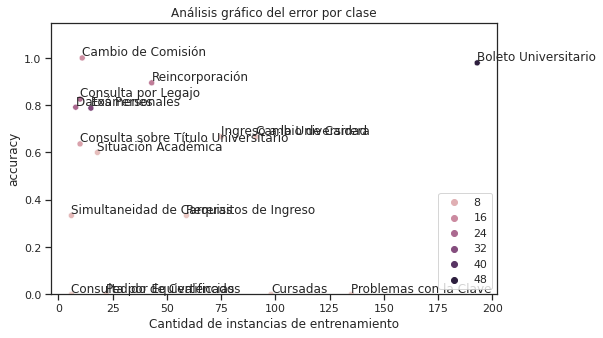

In [44]:
# Cargo las librerías y defino el paño blanco
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

# Ploteo el gráfico general
plt.figure(figsize=(8,5))

sns.scatterplot(data=df_train_error, 
                x="count_train", 
                y="accuracy", 
                hue="count_test")

# Pongo los nombres de las clases
for i in range(df_train_error.shape[0]):
#    if df_train_error.count_test[i]> df_train_error.count_test.mean():
      plt.text(x=df_train_error.count_train[i]+0.01,
              y=df_train_error.accuracy[i]+0.01,
              s=df_train_error.clase[i])

plt.title("Análisis gráfico del error por clase")           #title
# plt.xlim(df_error.score.min()-1,df_error.score.max()+1)   #set x limit
plt.ylim(0.0, 1.15)                                         #set y limit
plt.xlabel("Cantidad de instancias de entrenamiento")       #y label
plt.legend(loc='lower right')

## Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05